# Predict stock prices  with Long short-term memory (LSTM)

This simple example will show you how LSTM models predict time series data. Stock market data is a great choice for this because it's quite regular and widely available via the Internet. 

## Install requirements
We install Tensorflow 2.0 with GPU support first

In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!apt install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [4]:
!pip install pydot pydot-ng

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Introduction

LSTMs are very powerful in sequence prediction problems. They can store past information.

## Loading the dataset
I use pandas-datareader to get the historical stock prices from Yahoo! finance. For this example, I get only the historical data till the end of *training_end_data*.  

In [5]:
!pip install pandas_datareader -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data

In [7]:
!pip install yfinance pandas_datareader -Uq --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


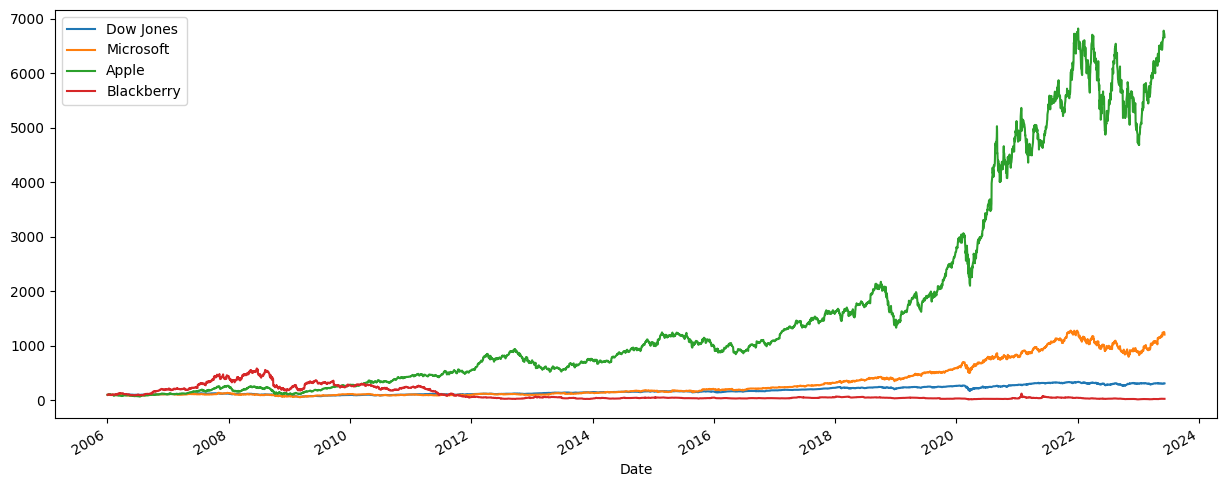

In [8]:
import numpy as np #python library for scientific computing
import pandas as pd #python library for data manipulation and analysis
import matplotlib.pyplot as plt #python library for charting
from pandas_datareader import data as pdr #extract data from internet sources into pandas data frame
import yfinance as yf

yf.pdr_override()
data = pdr.get_data_yahoo('^DJI', start='2006-01-01')
data2 = pdr.get_data_yahoo('MSFT', start='2006-01-01')
data3 = pdr.get_data_yahoo('AAPL', start='2006-01-01')
data4 = pdr.get_data_yahoo('BB.TO', start='2006-01-01')

ax = (data['Close'] / data['Close'].iloc[0] * 100).plot(figsize=(15, 6))
(data2['Close'] / data2['Close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
(data3['Close'] / data3['Close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
(data4['Close'] / data4['Close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))

plt.legend(['Dow Jones', 'Microsoft', 'Apple', 'Blackberry'], loc='upper left')
plt.show()

In [9]:
tickers = 'AAPL'

start_date = '1980-12-01'
end_date = '2018-12-31'

stock_data = pdr.get_data_yahoo(tickers, start_date)

[*********************100%***********************]  1 of 1 completed


In [10]:
stock_data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099584,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094388,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087461,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089625,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092224,73449600
1980-12-19,0.126116,0.126674,0.126116,0.126116,0.097852,48630400
1980-12-22,0.132254,0.132813,0.132254,0.132254,0.102614,37363200
1980-12-23,0.137835,0.138393,0.137835,0.137835,0.106945,46950400
1980-12-24,0.145089,0.145647,0.145089,0.145089,0.112573,48003200


In [11]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10711.000000,10711.000000,10711.000000,10711.000000,10711.000000,1.071100e+04
mean,17.883881,18.086785,17.687577,17.895480,17.184118,3.250071e+08
std,37.684253,38.133668,37.262481,37.718694,37.343361,3.371797e+08
min,0.049665,0.049665,0.049107,0.049107,0.038102,0.000000e+00
25%,0.290179,0.298828,0.283482,0.290737,0.239300,1.191196e+08
50%,0.494643,0.502232,0.486607,0.495179,0.410401,2.122624e+08
75%,17.701428,17.880000,17.471964,17.676964,15.313038,4.046462e+08
max,182.630005,184.949997,179.259995,182.009995,180.949997,7.421641e+09


In [12]:
stock_data_len = stock_data['Close'].count()
print(stock_data_len)

10711


I'm only interested in *close* prices

In [13]:
close_prices = stock_data.iloc[:, 1:2].values
print(close_prices)

[[1.28905997e-01]
 [1.22210003e-01]
 [1.13280997e-01]
 ...
 [1.84949997e+02]
 [1.80119995e+02]
 [1.81210007e+02]]


Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices

In [14]:
all_bussinessdays = pd.date_range(start=start_date, end=end_date, freq='B')
print(all_bussinessdays)

DatetimeIndex(['1980-12-01', '1980-12-02', '1980-12-03', '1980-12-04',
               '1980-12-05', '1980-12-08', '1980-12-09', '1980-12-10',
               '1980-12-11', '1980-12-12',
               ...
               '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21',
               '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27',
               '2018-12-28', '2018-12-31'],
              dtype='datetime64[ns]', length=9936, freq='B')


In [15]:
close_prices = stock_data.reindex(all_bussinessdays)
close_prices = stock_data.fillna(method='ffill')

In [16]:
close_prices.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099584,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094388,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087461,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089625,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092224,73449600
1980-12-19,0.126116,0.126674,0.126116,0.126116,0.097852,48630400
1980-12-22,0.132254,0.132813,0.132254,0.132254,0.102614,37363200
1980-12-23,0.137835,0.138393,0.137835,0.137835,0.106945,46950400
1980-12-24,0.145089,0.145647,0.145089,0.145089,0.112573,48003200


The dataset is now complete and free of missing values. Let's have a look to the data frame summary:

## Feature scaling

In [17]:
training_set = close_prices.iloc[:, 1:2].values

In [18]:
print(training_set)

[[1.28905997e-01]
 [1.22210003e-01]
 [1.13280997e-01]
 ...
 [1.84949997e+02]
 [1.80119995e+02]
 [1.81210007e+02]]


In [19]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled.shape)

(10711, 1)


LSTMs expect the data in a specific format, usually a 3D tensor. I start by creating data with 60 days and converting it into an array using NumPy. Next, I convert the data into a 3D dimension array with feature_set samples, 60 days and one feature at each step.

In [20]:
features = []
labels = []
for i in range(60, stock_data_len):
    features.append(training_set_scaled[i-60:i, 0])
    labels.append(training_set_scaled[i, 0])

features = np.array(features)
labels = np.array(labels)

features = np.reshape(features, (features.shape[0], features.shape[1], 1))

In [21]:
print(labels)

[2.59550623e-04 2.77657678e-04 2.71621993e-04 ... 1.00000000e+00
 9.73877809e-01 9.79772939e-01]


In [22]:
print(features)

[[[4.28560596e-04]
  [3.92346527e-04]
  [3.44055609e-04]
  ...
  [3.56126979e-04]
  [3.04823679e-04]
  [2.77657678e-04]]

 [[3.92346527e-04]
  [3.44055609e-04]
  [3.59144841e-04]
  ...
  [3.04823679e-04]
  [2.77657678e-04]
  [2.59550623e-04]]

 [[3.44055609e-04]
  [3.59144841e-04]
  [3.77257295e-04]
  ...
  [2.77657678e-04]
  [2.59550623e-04]
  [2.77657678e-04]]

 ...

 [[8.35532996e-01]
  [8.16063097e-01]
  [8.27961382e-01]
  ...
  [9.69713462e-01]
  [9.73877809e-01]
  [9.82855638e-01]]

 [[8.16063097e-01]
  [8.27961382e-01]
  [8.29367515e-01]
  ...
  [9.73877809e-01]
  [9.82855638e-01]
  [1.00000000e+00]]

 [[8.27961382e-01]
  [8.29367515e-01]
  [8.28556300e-01]
  ...
  [9.82855638e-01]
  [1.00000000e+00]
  [9.73877809e-01]]]


Feature tensor with three dimension: features[0] contains the ..., features[1] contains the last 60 days of values and features [2] contains the  ...

In [23]:
print(features.shape)

(10651, 60, 1)


## Create the LSTM network
Let's create a sequenced LSTM network with 50 units. Also the net includes some dropout layers with 0.2 which means that 20% of the neurons will be dropped.

In [24]:
import tensorflow as tf

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (features.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1)
])

In [26]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [27]:
#tf.keras.utils.plot_model(model, to_file='my_model.png')


In [28]:
# Run tensorboard with the logdir
#import os
#LOG_BASE_DIR = './log'
#os.makedirs(LOG_BASE_DIR, exist_ok=True)

In [29]:
#!ls -l log

## Load the Colab TensorBoard extention and start TensorBoard inline

In [30]:
#%load_ext tensorboard.notebook
#%tensorboard --logdir {LOG_BASE_DIR}

## Define a TensorBoard callback

In [31]:
#import datetime
#logdir = os.path.join(LOG_BASE_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [32]:
#from tensorflow.keras.callbacks import TensorBoard

#tbCallBack = TensorBoard(logdir,histogram_freq=1)

The model will be compiled and optimize by the adam optimizer and set the loss function as mean_squarred_error

In [33]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [34]:
#import os
#print(os.environ)

In [35]:
#tf.test.gpu_device_name()

In [36]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [37]:
from time import time
start = time()
history = model.fit(features, labels, epochs = 20, batch_size = 32, verbose = 1)
end = time()

Epoch 1/20
333/333 [==============================] - 21s 14ms/step - loss: 0.0022
Epoch 2/20
333/333 [==============================] - 5s 16ms/step - loss: 9.0541e-04
Epoch 3/20
333/333 [==============================] - 4s 13ms/step - loss: 7.1480e-04
Epoch 4/20
333/333 [==============================] - 5s 14ms/step - loss: 6.0183e-04
Epoch 5/20
333/333 [==============================] - 5s 16ms/step - loss: 6.2858e-04
Epoch 6/20
333/333 [==============================] - 4s 13ms/step - loss: 6.6595e-04
Epoch 7/20
333/333 [==============================] - 5s 15ms/step - loss: 5.6561e-04
Epoch 8/20
333/333 [==============================] - 5s 15ms/step - loss: 5.0570e-04
Epoch 9/20
333/333 [==============================] - 5s 14ms/step - loss: 5.5434e-04
Epoch 10/20
333/333 [==============================] - 5s 15ms/step - loss: 5.1162e-04
Epoch 11/20
333/333 [==============================] - 5s 14ms/step - loss: 4.8702e-04
Epoch 12/20
333/333 [==============================] - 

In [38]:
print('Total training time {} seconds'.format(end - start))

Total training time 151.98871564865112 seconds


In [39]:
#  [samples, days, features]
print(features.shape)

(10651, 60, 1)


In [40]:
testing_start_date = '2019-01-01'
testing_end_date = '2019-04-10'

test_stock_data = pdr.get_data_yahoo(tickers, testing_start_date, testing_end_date)

[*********************100%***********************]  1 of 1 completed


In [41]:
test_stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-03,48.312500,49.125000,48.287498,48.837502,47.201477,93087200
2019-04-04,48.697498,49.092499,48.285000,48.922501,47.283627,76457200
2019-04-05,49.112499,49.275002,48.982498,49.250000,47.600163,74106400
2019-04-08,49.105000,50.057499,49.084999,50.025002,48.349205,103526800
2019-04-09,50.080002,50.712502,49.807499,49.875000,48.204224,143072800


In [42]:
test_stock_data_processed = test_stock_data.iloc[:, 1:2].values


In [43]:
print(test_stock_data_processed.shape)

(68, 1)


In [44]:
all_stock_data = pd.concat((stock_data['Close'], test_stock_data['Close']), axis = 0)

In [45]:
inputs = all_stock_data[len(all_stock_data) - len(test_stock_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [46]:
X_test = []
for i in range(60, 129):
    X_test.append(inputs[i-60:i, 0])

In [47]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

3/3 [==============================] - 2s 9ms/step


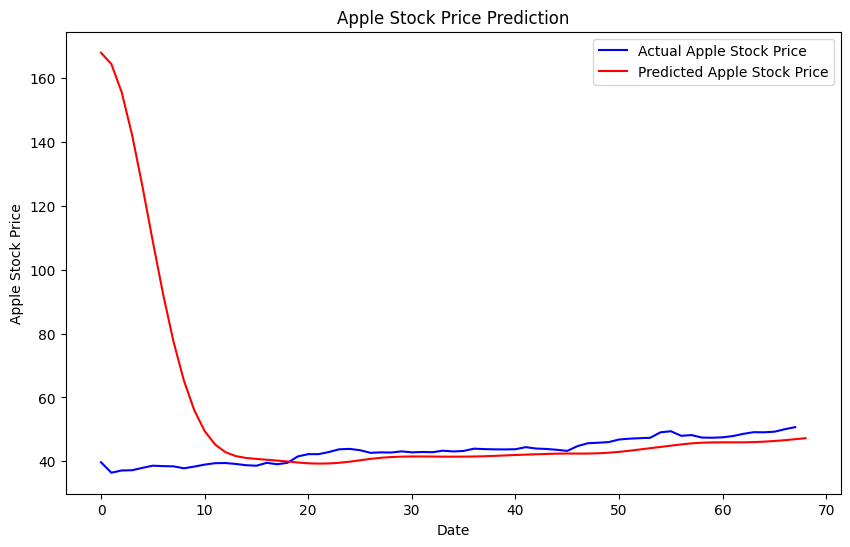

In [48]:
plt.figure(figsize=(10,6))  
plt.plot(test_stock_data_processed, color='blue', label='Actual Apple Stock Price')  
plt.plot(predicted_stock_price , color='red', label='Predicted Apple Stock Price')  
plt.title('Apple Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('Apple Stock Price')  
plt.legend()  
plt.show()  

In [49]:
#inputs = inputs.reshape(-1,1)
#inputs = sc.transform(inputs)


test_inputs = test_stock_data_processed.reshape(-1,1)
test_inputs = sc.transform(test_inputs)


print(test_inputs.shape)

(68, 1)


In [50]:
test_features = []
for i in range(60, 291):
    test_features.append(test_inputs[i-60:i, 0])
    
test_features = np.array(test_features)

<ipython-input-50-f283a14c8d89>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_features = np.array(test_features)


In [51]:
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))  
print(test_features.shape)

IndexError: ignored

In [ ]:
predicted_stock_price = model.predict(test_features)

In [ ]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price.shape)

In [ ]:
print(test_stock_data_processed.shape)

In [ ]:
plt.figure(figsize=(10,6))  
plt.plot(test_stock_data_processed, color='blue', label='Actual Apple Stock Price')  
plt.plot(predicted_stock_price , color='red', label='Predicted Apple Stock Price')  
plt.title('Apple Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('Apple Stock Price')  
plt.legend()  
plt.show()  

## Download the model and the weights

In [ ]:
from google.colab import files

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

In [ ]:
files.download("model.json")

In [ ]:
model.save('weights.h5')
files.download('weights.h5')